In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew, kurtosis, skewnorm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import ta
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import scipy.stats as stats
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
# Data source : https://www.mcxindia.com/market-data/historical-data#

In [42]:
df = pd.read_csv("Data/oil_data.csv")
df.head(5)

,Instrument Type,Date,Segment,Commodity,Traded Contract(Lots),Total Value (Lacs)
0,FUTCOM,01/01/2009,ENERGY,CRUDEOIL,31027,65539.83
1,FUTCOM,02/01/2009,ENERGY,CRUDEOIL,234853,500131.42
2,FUTCOM,03/01/2009,ENERGY,CRUDEOIL,4908,11188.69
3,FUTCOM,05/01/2009,ENERGY,CRUDEOIL,212593,489154.93
4,FUTCOM,06/01/2009,ENERGY,CRUDEOIL,230727,557364.60


In [43]:
print(df.isnull().sum())
print('\n')
print(df.shape)

Instrument Type          0
Date                     0
Segment                  0
Commodity                0
Traded Contract(Lots)    0
Total Value (Lacs)       0
dtype: int64


(4424, 6)


In [44]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst = True)
df = df.sort_values(by='Date')
df.head(5)

,Instrument Type,Date,Segment,Commodity,Traded Contract(Lots),Total Value (Lacs)
0,FUTCOM,2009-01-01,ENERGY,CRUDEOIL,31027,65539.83
1,FUTCOM,2009-01-02,ENERGY,CRUDEOIL,234853,500131.42
2,FUTCOM,2009-01-03,ENERGY,CRUDEOIL,4908,11188.69
3,FUTCOM,2009-01-05,ENERGY,CRUDEOIL,212593,489154.93
4,FUTCOM,2009-01-06,ENERGY,CRUDEOIL,230727,557364.60


1. FUTCOM stands for Future contracts of commodities
2. Total value (₹) = Price (₹) x Traded Contracts (measured in lots)
3. For oil, 1 lot = 100 barrels 
4. ∴ per barrel price = price of 1 lot / 100 

In [45]:
df["Price per Barrel"] = (df["Total Value (Lacs)"] * 100000) / (df["Traded Contract(Lots)"] * 100)
df.head(5)

,Instrument Type,Date,Segment,Commodity,Traded Contract(Lots),Total Value (Lacs),Price per Barrel
0,FUTCOM,2009-01-01,ENERGY,CRUDEOIL,31027,65539.83,2112.348277
1,FUTCOM,2009-01-02,ENERGY,CRUDEOIL,234853,500131.42,2129.550911
2,FUTCOM,2009-01-03,ENERGY,CRUDEOIL,4908,11188.69,2279.684189
3,FUTCOM,2009-01-05,ENERGY,CRUDEOIL,212593,489154.93,2300.898571
4,FUTCOM,2009-01-06,ENERGY,CRUDEOIL,230727,557364.60,2415.688671


In [46]:
print(df.isnull().sum())
print('\n')
print(df.shape)

Instrument Type           0
Date                      0
Segment                   0
Commodity                 0
Traded Contract(Lots)     0
Total Value (Lacs)        0
Price per Barrel         28
dtype: int64


(4424, 7)


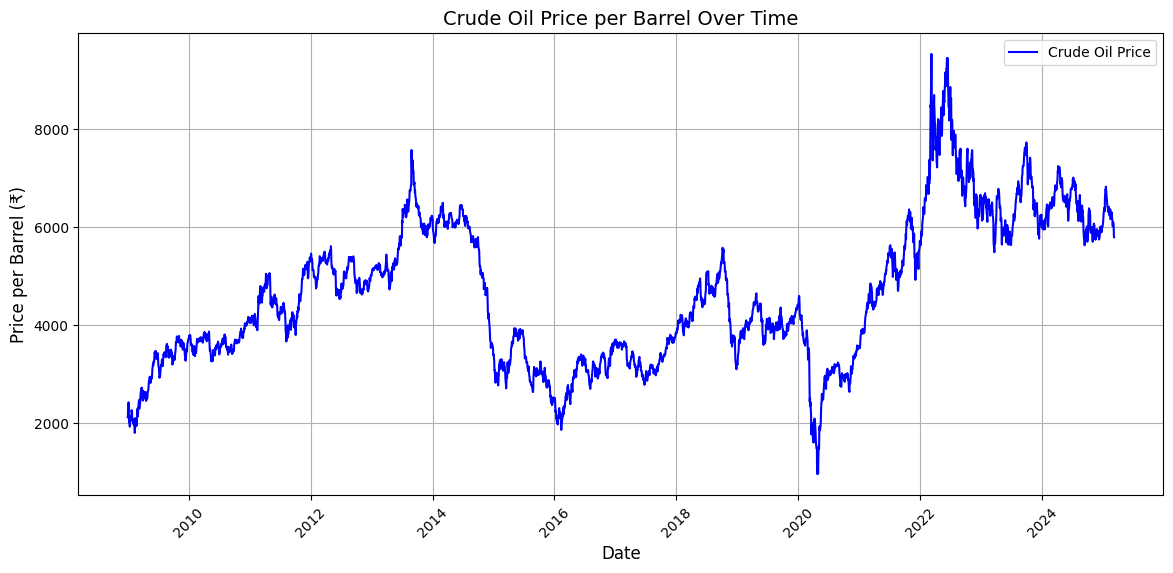

In [47]:
df["Date"] = pd.to_datetime(df["Date"])

df = df.sort_values("Date")

plt.figure(figsize=(14, 6))

sns.lineplot(x=df["Date"], y=df["Price per Barrel"], color="blue", label="Crude Oil Price")

plt.xlabel("Date", fontsize=12)
plt.ylabel("Price per Barrel (₹)", fontsize=12)
plt.title("Crude Oil Price per Barrel Over Time", fontsize=14)
plt.xticks(rotation=45)  
plt.grid(True)
plt.legend()
plt.show()

* 2022 Peak - Russian Invasion of Ukraine.
    EU's NATO backing Ukraine implied russia's stoppage of oil export to EU ==> Supply fall ==> Price increase
* 2020 Trough - Covid 19
    Many sectors such as aviation were shut down ==> Fall in demand ==> Price fall
* 2018 Peak - Geopolitical tensions & supply cuts
    US reimposed sanctions on Iran, reducing its oil exports ==> Supply fall ==> Price increase
* 2014 - 2016 Trough - Oil Price Crash of 2014-2016
    OPEC (led by Saudi Arabia) decided not to cut production, leading to an oversupply. US shale oil boom increased global supply ==> Price decrease

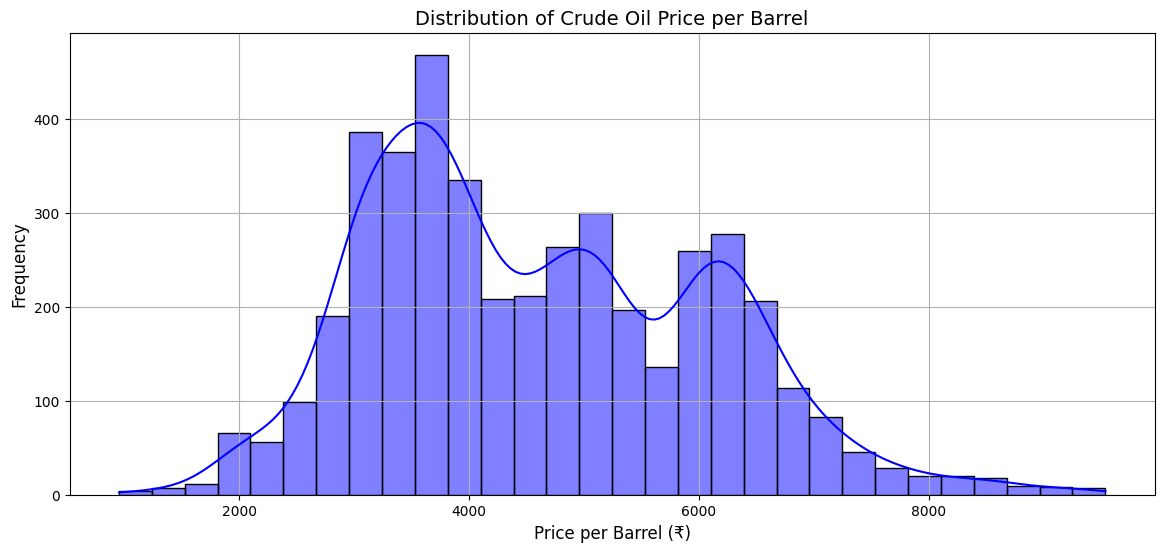

In [48]:
plt.figure(figsize=(14, 6))

sns.histplot(df["Price per Barrel"], kde=True, color="blue", bins=30)  # You can adjust bins as needed

plt.xlabel("Price per Barrel (₹)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Crude Oil Price per Barrel", fontsize=14)
plt.grid(True)
plt.show()


In [49]:
df["Price per Barrel"].mean()

np.float64(4602.576034948103)

In [50]:
df["Price per Barrel"].median()

np.float64(4390.863666831919)

In [51]:
median = df['Price per Barrel'].median()
deviation_price = ( df["Price per Barrel"].tail(1).iloc[0] - median) / median * 100
print(f"Deviation for latest value = {round(deviation_price,2)} %")

Deviation for latest value = 31.83 %


In [52]:
hist_deviations = []
dates = []
for i in range (len(df)):
    median = df["Price per Barrel"].median()
    date = df["Date"].tail(1).iloc[0]
    deviation_price = ( df["Price per Barrel"].tail(1).iloc[0] - median) / median * 100
    hist_deviations.append(round(deviation_price,2))
    dates.append(date)
    df = df.iloc[:-1]

In [53]:
print(len(hist_deviations))
print(len(dates))
dev_min = min(hist_deviations)
dev_max = max(hist_deviations)
print(dev_min, dev_max)

4424
4424
-75.54 140.96


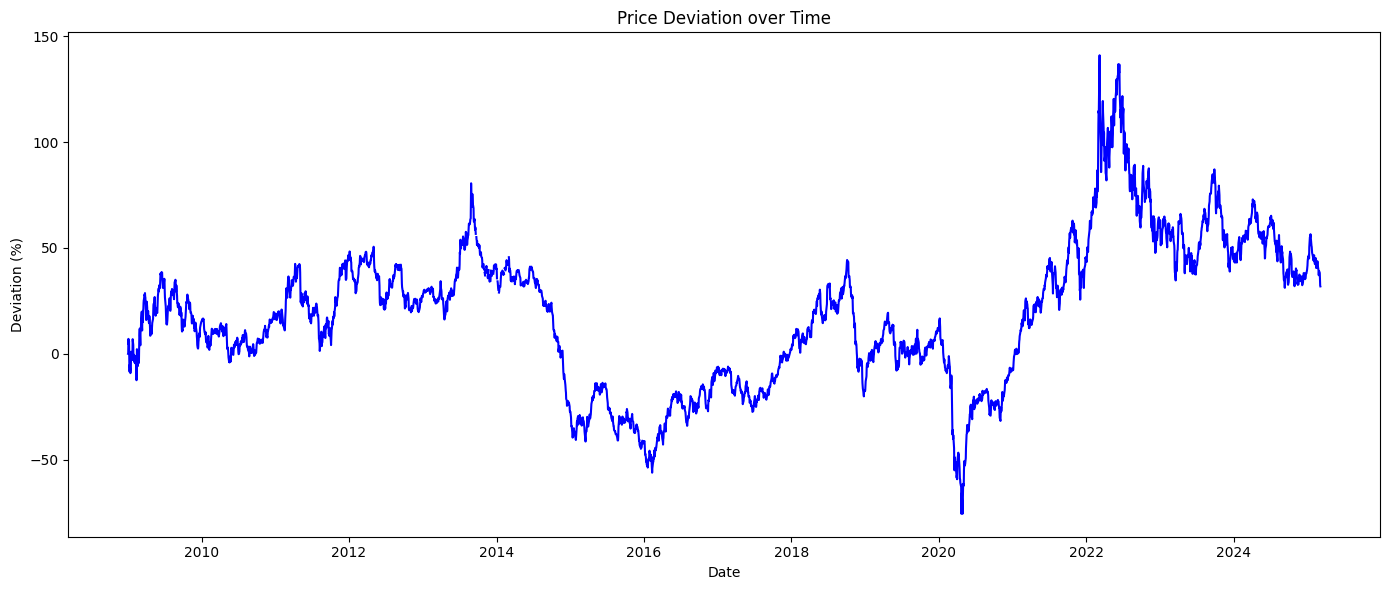

In [54]:
plt.figure(figsize=(14, 6))

median_deviation = np.median(hist_deviations)
plt.axhline(y=median_deviation, color='r', linestyle='--', label=f'Median ({median_deviation:.2f}%)')


plt.plot(dates, hist_deviations,  linestyle='-', color='b')

plt.title('Price Deviation over Time')
plt.xlabel('Date')
plt.ylabel('Deviation (%)')

plt.tight_layout()
plt.show()

In [55]:
pve = 0
nve = 0
for i in hist_deviations:
    if i>0:
        pve += 1 
    else:
        nve += 1
print(pve/len(hist_deviations))

gt25 = 0
lt25 = 0
mid = 0
for i in hist_deviations:
    if i < -0.5:
        lt25+=1
    elif i > 25:
        gt25+=1
    else:
        mid+=1
print(mid/len(hist_deviations), gt25/len(hist_deviations), lt25/len(hist_deviations))

0.7215189873417721
0.2981464737793852 0.43625678119349004 0.26559674502712477


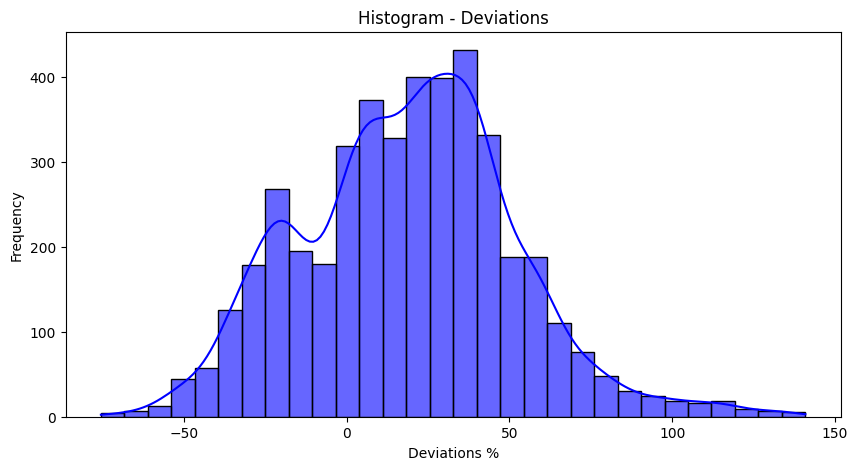

In [56]:
plt.figure(figsize=(10, 5))
sns.histplot(hist_deviations, bins=30, kde=True, color="blue", alpha=0.6)
plt.title("Histogram - Deviations")
plt.xlabel("Deviations %")
plt.ylabel("Frequency")
plt.show()

In [57]:
print(np.any(np.isnan(hist_deviations)))

True


In [58]:
hist_deviations = np.array(hist_deviations)
hist_deviations = hist_deviations[~np.isnan(hist_deviations)]

skewness = skew(hist_deviations)
kurt = kurtosis(hist_deviations)

print(f"Skewness: {skewness:.4f}")
print(f"Kurtosis: {kurt:.4f}")

Skewness: 0.2221
Kurtosis: 0.2540


So it is positive tailed

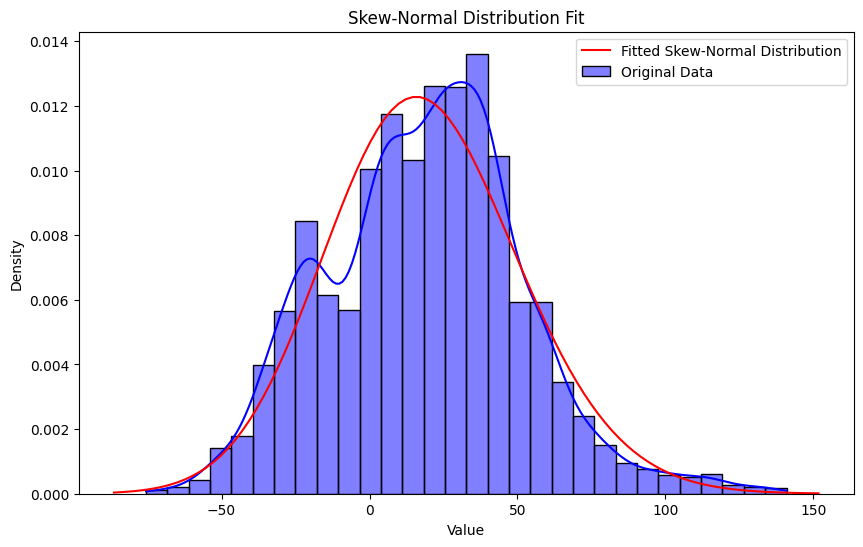

In [59]:
params = skewnorm.fit(hist_deviations)
a, loc, scale = params

plt.figure(figsize=(10, 6))  

sns.histplot(hist_deviations, kde=True, stat="density", color='blue', label='Original Data', bins=30)

xmin, xmax = plt.xlim()  
x = np.linspace(xmin, xmax, 100)
p = skewnorm.pdf(x, a, loc, scale)
plt.plot(x, p, 'r-', label="Fitted Skew-Normal Distribution")

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Skew-Normal Distribution Fit')
plt.legend()

plt.show()

Now it kinda looks like it fits in skew-normal. Though not perfect I think its fine for the trial.

The probability density function (PDF) of a **skew-normal distribution** is :

$$
f(x; \alpha, \mu, \sigma) = \frac{2}{\sigma} \phi \left( \frac{x - \mu}{\sigma} \right) \Phi \left( \alpha \cdot \frac{x - \mu}{\sigma} \right)
$$

Where:

- $ x $ is the variable (deviation).
- $ \mu $ is the mean 
- $ \sigma $ is the standard deviation 
- $ \alpha $ determines the skewness :
    - $ \alpha = 0 $ gives the normal distribution.
    - Positive $ \alpha $ gives right skew.
    - Negative $ \alpha $ gives left skew.
- $ \phi(z) $ is the PDF of the standard normal distribution:
$$
\phi(z) = \frac{1}{\sqrt{2\pi}} e^{-\frac{z^2}{2}}
$$
- $ \Phi(z) $ is the cumulative distribution function (CDF) of the standard normal distribution:
$$
\Phi(z) = \int_{-\infty}^{z} \frac{1}{\sqrt{2\pi}} e^{-\frac{t^2}{2}} dt
$$


In [64]:
current_price = float(input("Enter the current oil level's price"))

x = float((current_price - median ) / median * 100)

cdf = skewnorm.cdf(x, a , loc=loc, scale=scale)

prob_increasing = 1 - cdf

prob_decreasing = cdf

print(f"Deviation from fair value is {x : .2f} %")
print(f"Probability of index increasing: {prob_increasing*100:.2f} %")
print(f"Probability of index decreasing: {prob_decreasing*100:.2f} %")

Deviation from fair value is -20.29 %
Probability of index increasing: 77.27 %
Probability of index decreasing: 22.73 %


In [61]:
def calc_prob(x, a, loc, scale, current_price, current_pe, median_pe):

    cdf = skewnorm.cdf(x, a , loc=loc, scale=scale)

    prob_increasing = round((1 - cdf)*100,2)

    prob_decreasing = round(cdf*100,2)
    
    return prob_increasing, prob_decreasing

# Caution : Computation Time

In [ ]:
df = pd.read_csv("Data/oil_data.csv")
df["Price per Barrel"] = (df["Total Value (Lacs)"] * 100000) / (df["Traded Contract(Lots)"] * 100)

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(by='Date').reset_index(drop=True)

initial_days = 1000
forecast_horizon = 126

results = []
i = 0
for start in range(initial_days, len(df) - forecast_horizon):

    historical_data = df.iloc[:start]

    median = df["Price per Barrel"].median()

    current_row = df.iloc[start]

    deviation = (current_row["Price per Barrel"] - median) / median * 100

    historical_deviations = (historical_data['Price per Barrel'] - median) / median * 100
    
    historical_deviations = np.array(historical_deviations)
    historical_deviations = historical_deviations[~np.isnan(historical_deviations)]

    a, loc, scale = skewnorm.fit(historical_deviations)

    cdf = skewnorm.cdf(deviation, a, loc=loc, scale=scale)
    prob_increasing = 1 - cdf
    prob_decreasing = cdf

    prediction = 'Up' if prob_increasing > prob_decreasing else 'Down'
    
    future_close = df.iloc[start + forecast_horizon]['Price per Barrel']
    actual_movement = 'Up' if future_close > current_row['Price per Barrel'] else 'Down'
    
    results.append([
        current_row['Date'], prob_increasing, prob_decreasing, prediction, actual_movement
    ])
    print(i)
    i+=1
    

results_df = pd.DataFrame(results, columns=['Date', 'Prob_Up', 'Prob_Down', 'Prediction', 'Actual'])
results_df.to_csv('binary_results.csv', index=False)

print("Backtest complete")

In [63]:
df_results = pd.read_csv("binary_results.csv")
df_results

,Date,Prob_Up,Prob_Down,Prediction,Actual
0,2012-04-04,0.035219,0.964781,Down,Up
1,2012-04-05,0.036004,0.963996,Down,Up
2,2012-04-07,0.032773,0.967227,Down,Up
3,2012-04-09,0.039298,0.960702,Down,Up
4,2012-04-10,0.036644,0.963356,Down,Up
...,...,...,...,...,...
3293,2024-09-04,0.173463,0.826537,Down,Up
3294,2024-09-05,0.178458,0.821542,Down,Up
3295,2024-09-06,0.191278,0.808722,Down,Up
3296,2024-09-09,0.196914,0.803086,Down,Up


In [ ]:
success = 0
fail = 0 
total = len(df_results)

for i in range(total):
    if df_results["Prediction"].iloc[i] == df_results["Actual"].iloc[i]:
        success += 1
    else:
        fail += 1

print(f"Success rate: {success / total:.2f}")

Success rate: 0.59


In [ ]:
median = historical_data['Price per Barrel'].median()

historical_deviations = (historical_data['Price per Barrel'] - median) / median * 100

df["dev"] = historical_deviations

df["dev"] = historical_deviations.reindex(df.index)

In [ ]:
df

,Instrument Type,Date,Segment,Commodity,Traded Contract(Lots),Total Value (Lacs),Price per Barrel,dev
0,FUTCOM,2009-01-01,ENERGY,CRUDEOIL,31027,65539.83,2112.348277,-50.715473
1,FUTCOM,2009-01-02,ENERGY,CRUDEOIL,234853,500131.42,2129.550911,-50.314108
2,FUTCOM,2009-01-03,ENERGY,CRUDEOIL,4908,11188.69,2279.684189,-46.811254
3,FUTCOM,2009-01-05,ENERGY,CRUDEOIL,212593,489154.93,2300.898571,-46.316287
4,FUTCOM,2009-01-06,ENERGY,CRUDEOIL,230727,557364.60,2415.688671,-43.638047
...,...,...,...,...,...,...,...,...
4419,FUTCOM,2025-02-28,ENERGY,CRUDEOIL,10139,61845.58,6099.771181,NaN
4420,FUTCOM,2025-03-03,ENERGY,CRUDEOIL,19287,116985.98,6065.535335,NaN
4421,FUTCOM,2025-03-04,ENERGY,CRUDEOIL,22858,135123.45,5911.429259,NaN
4422,FUTCOM,2025-03-05,ENERGY,CRUDEOIL,32737,189928.66,5801.651343,NaN


R² Score: 1.00
Mean Squared Error: 0.00


C:\Users\sanja\AppData\Local\Temp\ipykernel_23144\52434068.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', color="red")


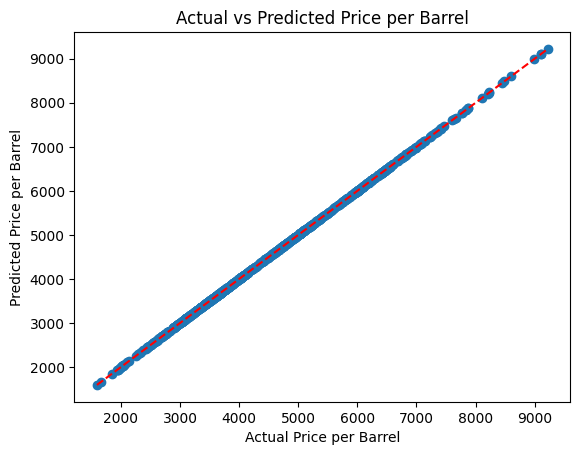

In [ ]:
df_clean = df.dropna(subset=["dev", "Price per Barrel"])

X = df_clean[["dev"]]
y = df_clean["Price per Barrel"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', color="red")
plt.xlabel("Actual Price per Barrel")
plt.ylabel("Predicted Price per Barrel")
plt.title("Actual vs Predicted Price per Barrel")
plt.show()

Technical features : 
1. RSI : relative strength index : give values b/w 0 & 100. <30 ==> oversold region. >70 ==> overbought
2. SMA : Simple moving average : take avg price over n period
3. Bollinger band - SMA but has an upper and lower band, each 2 sigma away from SMA
4. Moving average convergence / divergence - MACD : 12-26 period EMA (exponential MA : gives more weight to recent trend)

Multiple Linear Regression's 5 assumptions : 

1. Linearity
2. No Multicollinearity
3. Homoscedasticity
4. No Autocorrelation in Residuals
5. Normality of Residuals

Linearity of features

Price per Barrel    1.000000
Boll_Lower          0.979696
Boll_Upper          0.979257
SMA_50              0.963743
SMA_200             0.868492
MACD                0.237637
RSI                 0.167568
Name: Price per Barrel, dtype: float64


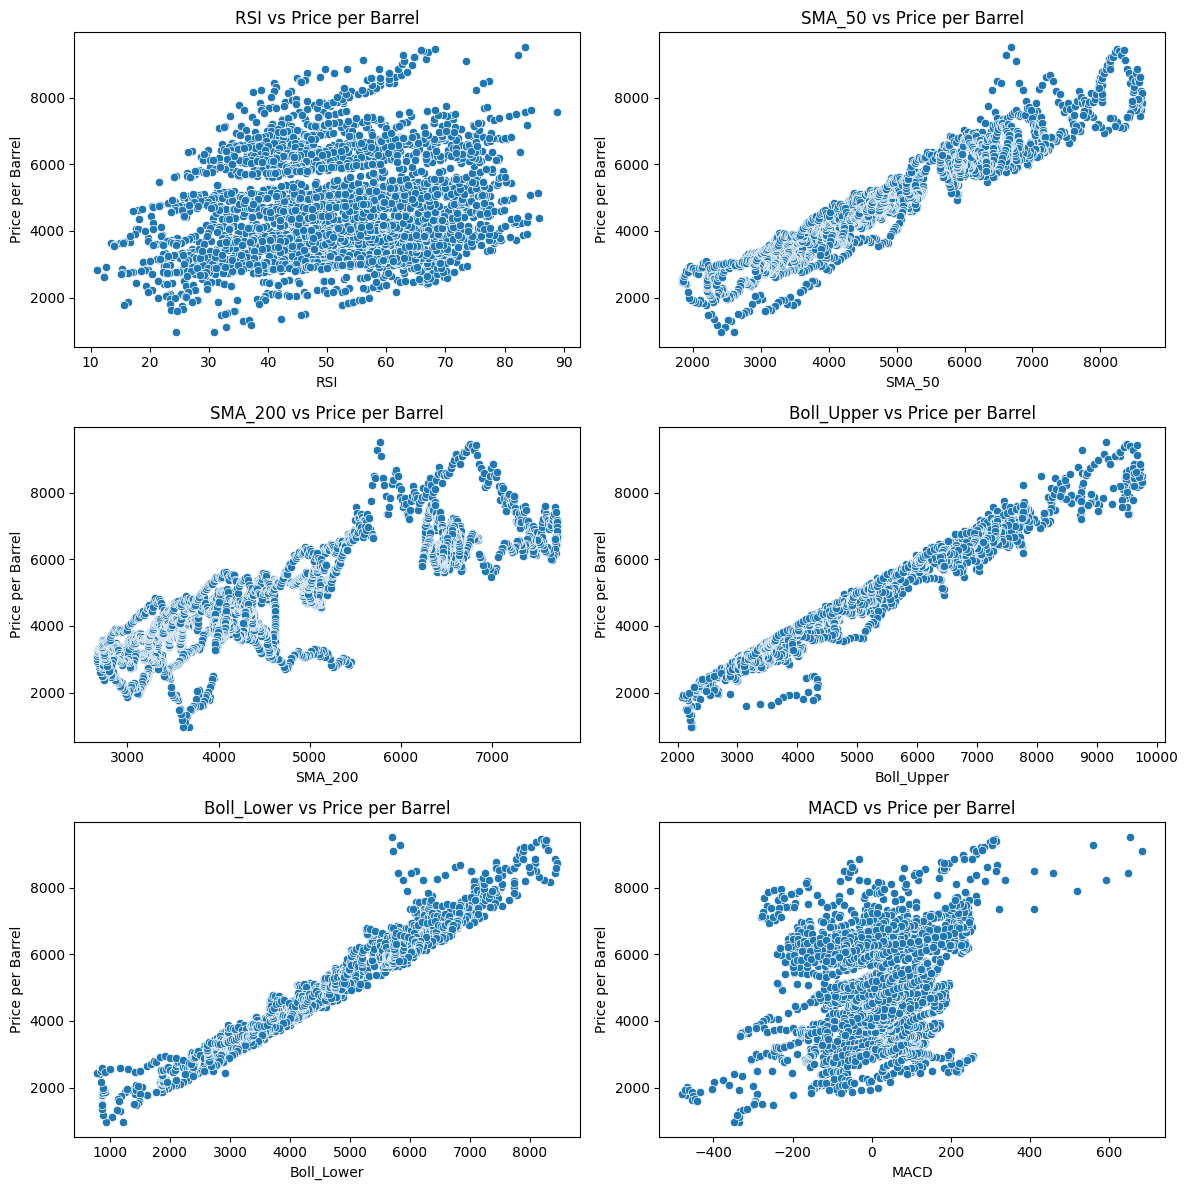

In [ ]:
correlation_matrix = df[['Price per Barrel', 'RSI', 'SMA_50', 'SMA_200', 'Boll_Upper', 'Boll_Lower', 'MACD']].corr()
print(correlation_matrix['Price per Barrel'].sort_values(ascending=False))

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

features = ['RSI', 'SMA_50', 'SMA_200', 'Boll_Upper', 'Boll_Lower', 'MACD']

for i, feature in enumerate(features):
    ax = axes[i//2, i%2]
    sns.scatterplot(x=df[feature], y=df['Price per Barrel'], ax=ax)
    ax.set_title(f'{feature} vs Price per Barrel')

plt.tight_layout()
plt.show()

Multicollinearity check

In [ ]:
X = df[['RSI', 'SMA_50', 'SMA_200', 'Boll_Upper', 'Boll_Lower', 'MACD']]
X = sm.add_constant(X)
vif = pd.DataFrame({'Feature': X.columns, 'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]})
print(vif)

      Feature         VIF
0       const   55.551729
1         RSI    3.059168
2      SMA_50  171.631494
3     SMA_200    7.196027
4  Boll_Upper   66.747885
5  Boll_Lower   48.732557
6        MACD    7.590558


3. Homoskedasticity

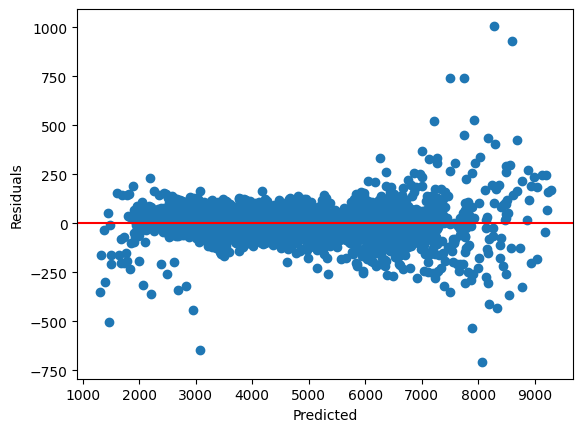

In [ ]:
model = sm.OLS(df['Price per Barrel'], X).fit()
residuals = model.resid
plt.scatter(model.fittedvalues, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(0, color='red')
plt.show()

Normality of residuals

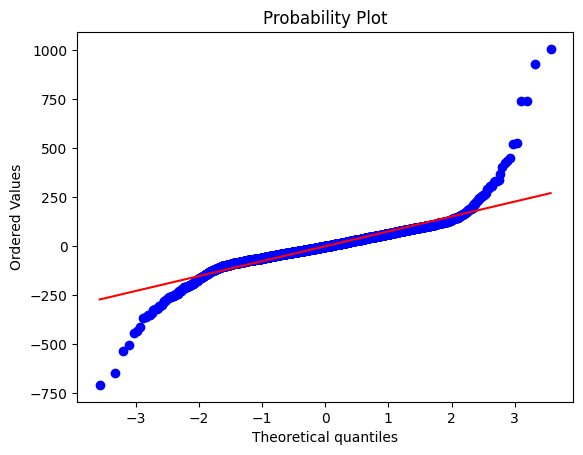

In [ ]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

In [65]:
df['RSI'] = ta.momentum.RSIIndicator(df['Price per Barrel']).rsi()
df['SMA_50'] = df['Price per Barrel'].rolling(window=50).mean()
df['SMA_200'] = df['Price per Barrel'].rolling(window=200).mean()
df['Boll_Upper'] = ta.volatility.BollingerBands(df['Price per Barrel']).bollinger_hband()
df['Boll_Lower'] = ta.volatility.BollingerBands(df['Price per Barrel']).bollinger_lband()
df['MACD'] = ta.trend.MACD(df['Price per Barrel']).macd()
df.dropna(inplace=True)

X = df[['SMA_200', 'MACD', 'RSI']]
y = df['Price per Barrel']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R2 Score: {r2}')

MSE: 258107.68086852416
R2 Score: 0.8665628534937062


In [66]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f'Cross-Validation R2 Scores: {scores}')
print(f'Mean R2: {scores.mean()}')

Cross-Validation R2 Scores: [0.71103079 0.73043307 0.66917389 0.76982102 0.19336833]
Mean R2: 0.6147654203821518


In [67]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')
print(f'Time-Series CV Mean R2: {scores.mean()}')

Time-Series CV Mean R2: -0.36222696347050903


XGBoost : 

Basically XGBoost is an ensemble learner (combination of many weak learner). It uses greadient boosting

Gradient boosting : weak learners are trained sequentially. Each weak learner is slightly better than a coin toss but they can detect and use complex relations b/w features. The prev errors are corrected in the next tree

XGBoost Time-Series CV Mean R2|: 0.7681592991403102


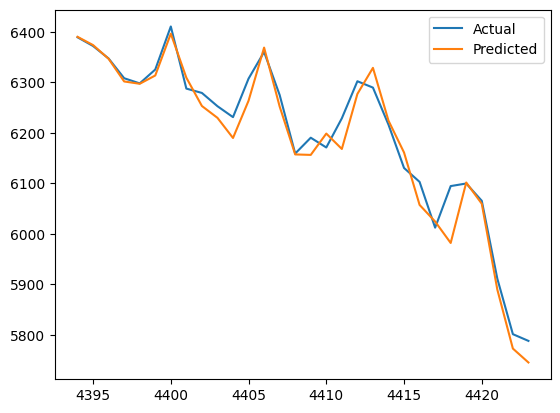

In [37]:
df['RSI'] = ta.momentum.RSIIndicator(df['Price per Barrel']).rsi()
df['SMA_50'] = df['Price per Barrel'].rolling(window=50).mean()
df['SMA_200'] = df['Price per Barrel'].rolling(window=200).mean()
df['Boll_Upper'] = ta.volatility.BollingerBands(df['Price per Barrel']).bollinger_hband()
df['Boll_Lower'] = ta.volatility.BollingerBands(df['Price per Barrel']).bollinger_lband()
df['MACD'] = ta.trend.MACD(df['Price per Barrel']).macd()
df['Lag_1'] = df['Price per Barrel'].shift(1)
df['Lag_5'] = df['Price per Barrel'].shift(5)
df['Lag_10'] = df['Price per Barrel'].shift(10)
df.dropna(inplace=True)

X = df[['SMA_200', 'MACD', 'RSI', 'Lag_1', 'Lag_5', 'Lag_10']]
y = df['Price per Barrel']

tscv = TimeSeriesSplit(n_splits=5)
model = XGBRegressor(n_estimators=100, learning_rate=0.1)

scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')
print(f'XGBoost Time-Series CV Mean R2|: {scores.mean()}')

model.fit(X, y)
future_pred = model.predict(X.tail(30))
plt.plot(df.index[-30:], df['Price per Barrel'].tail(30), label='Actual')
plt.plot(df.index[-30:], future_pred, label='Predicted')
plt.legend()
plt.show()

# Caution : Computation time

Hyperparameter tuning for XGBoost

In [ ]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, scoring='r2', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Optimized XGBoost MSE: {mse}')
print(f'Optimized XGBoost R2 Score: {r2}')
print(f'Best Parameters: {grid_search.best_params_}')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Optimized XGBoost MSE: 130057.29614935008
Optimized XGBoost R2 Score: 0.9327626577322456
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}


In [22]:
df = pd.read_csv("Data/oil_data.csv")
df["Price per Barrel"] = (df["Total Value (Lacs)"] * 100000) / (df["Traded Contract(Lots)"] * 100)
df['Date'] = pd.to_datetime(df['Date'], dayfirst = True)
df = df.sort_values(by='Date')
df.head(5)

,Instrument Type,Date,Segment,Commodity,Traded Contract(Lots),Total Value (Lacs),Price per Barrel
0,FUTCOM,2009-01-01,ENERGY,CRUDEOIL,31027,65539.83,2112.348277
1,FUTCOM,2009-01-02,ENERGY,CRUDEOIL,234853,500131.42,2129.550911
2,FUTCOM,2009-01-03,ENERGY,CRUDEOIL,4908,11188.69,2279.684189
3,FUTCOM,2009-01-05,ENERGY,CRUDEOIL,212593,489154.93,2300.898571
4,FUTCOM,2009-01-06,ENERGY,CRUDEOIL,230727,557364.60,2415.688671


# Caution : Computation time

In [25]:
df['RSI'] = ta.momentum.RSIIndicator(df['Price per Barrel']).rsi()
df['SMA_50'] = df['Price per Barrel'].rolling(window=50).mean()
df['SMA_200'] = df['Price per Barrel'].rolling(window=200).mean()
df['Boll_Upper'] = ta.volatility.BollingerBands(df['Price per Barrel']).bollinger_hband()
df['Boll_Lower'] = ta.volatility.BollingerBands(df['Price per Barrel']).bollinger_lband()
df['MACD'] = ta.trend.MACD(df['Price per Barrel']).macd()
df.dropna(inplace=True)

X = df[['SMA_200', 'MACD', 'RSI']]
y = df['Price per Barrel']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print(f'Best Hyperparameters: {grid_search.best_params_}')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Optimized Random Forest MSE: {mse}')
print(f'Optimized Random Forest R2 Score: {r2}')

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Optimized Random Forest MSE: 143547.27212906684
Optimized Random Forest R2 Score: 0.9307329668388307


To do : 

* Fundamental features
* Try 